<a href="https://colab.research.google.com/github/ravitata/tensorflow2/blob/master/c2w4_Coding_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
print(tf.__version__)

2.3.0


# Model subclassing and custom training loops

 ## Coding tutorials
 #### [1. Model subclassing](#coding_tutorial_1)
 #### [2. Custom layers](#coding_tutorial_2)
 #### [3. Automatic differentiation](#coding_tutorial_3)
 #### [4. Custom training loops](#coding_tutorial_4)
 #### [5. tf.function decorator](#coding_tutorial_5)

***
<a id="coding_tutorial_1"></a>
## Model subclassing

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Softmax, concatenate

#### Create a simple model using the model subclassing API

In [3]:
# Build the model #1
class MyModel(Model):
  def __init__(self, **kwargs):
    super(MyModel, self).__init__(**kwargs)
    self.dense_1=Dense(64, activation='relu')
    self.dense_2=Dense(10)
    self.dropout = Dropout(0.4)
  
  def call(self, inputs, training = True):
    d = self.dense_1(inputs)
    if training:
      d = self.dropout(d)
    return self.dense_2(d)


In [4]:
# Print the model summary

model = MyModel()
model(tf.random.uniform([1, 10]), True)
model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  704       
_________________________________________________________________
dense_1 (Dense)              multiple                  650       
_________________________________________________________________
dropout (Dropout)            multiple                  0         
Total params: 1,354
Trainable params: 1,354
Non-trainable params: 0
_________________________________________________________________


In [5]:
print(10*64+64)
print(64*10+10)

704
650


In [6]:
# Build the model #2
class MyModel(Model):
  def __init__(self, **kwargs):
    super(MyModel, self).__init__(**kwargs)
    self.dense_1=Dense(64, activation='relu')
    self.dense_2=Dense(10)
    self.dense_3=Dense(5)
    self.softmax = Softmax()
  
  def call(self, inputs, training = True):
    dl1 = self.dense_1(inputs)
    dl2 = self.dense_2(inputs)
    dl3 = self.dense_3(dl2)
    return self.softmax(concatenate([dl1, dl3]))


In [7]:
# Print the model summary

model = MyModel()
model(tf.random.uniform([1, 10]))
model.summary()

Model: "my_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              multiple                  704       
_________________________________________________________________
dense_3 (Dense)              multiple                  110       
_________________________________________________________________
dense_4 (Dense)              multiple                  55        
_________________________________________________________________
softmax (Softmax)            multiple                  0         
Total params: 869
Trainable params: 869
Non-trainable params: 0
_________________________________________________________________


In [8]:
print(10*64+64)
print(10*10+10)
print(10*5+5)

704
110
55


***
<a id="coding_tutorial_2"></a>
## Custom layers

In [9]:
print(tf.ones((3,))*0.1)
print(tf.ones((2,3)))
print(tf.reduce_sum(tf.ones((2,3)), axis=0))

print(tf.ones((3,))*0.1+tf.ones((2,3)))

tf.Tensor([0.1 0.1 0.1], shape=(3,), dtype=float32)
tf.Tensor(
[[1. 1. 1.]
 [1. 1. 1.]], shape=(2, 3), dtype=float32)
tf.Tensor([2. 2. 2.], shape=(3,), dtype=float32)
tf.Tensor(
[[1.1 1.1 1.1]
 [1.1 1.1 1.1]], shape=(2, 3), dtype=float32)


In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax

#### Create custom layers

In [11]:
# Create a custom layer
class MyLayer(Layer):
  def __init__(self, units, input_dims, **kwargs):
    super(MyLayer, self).__init__(**kwargs)
    self.w = self.add_weight(shape=(input_dims, units),
                              initializer = 'random_normal')
    self.b = self.add_weight(shape=(units,),
                              initializer = 'zeros')
  
  def call(self, inputs):
    return tf.matmul(inputs, self.w)+self.b

dense_layer = MyLayer(3, 5)
x = tf.ones([3, 5])
print(dense_layer(x))
print()
print(dense_layer.weights)



tf.Tensor(
[[-0.31820598 -0.19529817  0.10343248]
 [-0.31820598 -0.19529817  0.10343248]
 [-0.31820598 -0.19529817  0.10343248]], shape=(3, 3), dtype=float32)

[<tf.Variable 'Variable:0' shape=(5, 3) dtype=float32, numpy=
array([[-0.0819759 , -0.04058618, -0.00326149],
       [-0.04040538,  0.00889558,  0.04144095],
       [-0.04062394, -0.0637196 ,  0.0299923 ],
       [-0.07350152, -0.00281865,  0.02475185],
       [-0.08169924, -0.09706932,  0.01050888]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]


In [51]:
# Specify trainable weights
# Create a custom layer
class MyLayer(Layer):
  def __init__(self, units, input_dims, **kwargs):
    super(MyLayer, self).__init__(**kwargs)
    self.w = self.add_weight(shape=(input_dims, units),
                             initializer = 'random_normal',
                             trainable=False)
    self.b = self.add_weight(shape=(units,),
                             initializer = 'zeros',
                             trainable=False)
  
  def call(self, inputs):
    return tf.matmul(inputs, self.w)+self.b

dense_layer = MyLayer(3, 5)
x = tf.ones([3, 5])

In [52]:
print('trainable weights:', len(dense_layer.trainable_weights))
print('non-trainable weights:', len(dense_layer.non_trainable_weights))

trainable weights: 0
non-trainable weights: 2


In [53]:
# Create a custom layer to accumulate means of output values

class MyAccuLayer(Layer):
  def __init__(self, units, input_dims, **kwargs):
    super(MyAccuLayer, self).__init__(**kwargs)
    self.w = self.add_weight(shape=(input_dims, units),
                             initializer = 'random_normal',
                             trainable=True)
    self.b = self.add_weight(shape=(units,),
                             initializer = 'zeros',
                             trainable=True)
    self.sum_activations = tf.Variable(initial_value=tf.zeros(units, 1),
                                       trainable = False)
    self.sum_numbercalls = tf.Variable(initial_value=0,
                                       trainable = False)
  
  def call(self, inputs):
    activations = tf.matmul(inputs, self.w) + self.b
    self.sum_activations.assign_add(tf.reduce_sum(activations, axis=0))
    self.sum_numbercalls.assign_add(inputs.shape[0])
    return activations, self.sum_activations/tf.cast(self.sum_numbercalls, dtype=tf.float32)

dense_layer = MyAccuLayer(3, 5)


In [54]:
# Test the layer
#print(dense_layer.weights)

print('trainable weights:', len(dense_layer.trainable_weights))
print('non-trainable weights:', len(dense_layer.non_trainable_weights))

y, activation_means = dense_layer(tf.ones((4, 5)))
#print(y)
print(activation_means.numpy())

#print(dense_layer.weights)

y, activation_means = dense_layer(tf.ones((4, 5)))
#print(y)
print(activation_means.numpy())


trainable weights: 2
non-trainable weights: 2
[-0.04860301 -0.1812087   0.01455377]
[-0.04860301 -0.1812087   0.01455377]


In [63]:
# Create a Dropout layer as a custom layer

class MyDropout(Layer):

    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate
        
    def call(self, inputs):
        # Define forward pass for dropout layer
        return tf.nn.dropout(inputs, rate=self.rate)

#### Implement the custom layers into a model

In [66]:
# Build the model using custom layers with the model subclassing API

class MyModel(Model):

    def __init__(self, units_1, input_dim_1, units_2, units_3):
        super(MyModel, self).__init__()
        # Define layers
        self.layer_1 = MyLayer(units_1, input_dim_1)
        self.dropout_1 = MyDropout(0.5)
        self.layer_2 = MyLayer(units_2, units_1)
        self.dropout_2 = MyDropout(0.5)
        self.layer_3 = MyLayer(units_3, units_2)
        self.softmax = Softmax()
    def call(self, inputs):
        # Define forward pass
        x = self.layer_1(inputs)
        x = tf.nn.relu(x)
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x = tf.nn.relu(x)
        x = self.dropout_2(x)
        x = self.layer_3(x)
        return self.softmax(x)

In [67]:
# Instantiate a model object

model = MyModel(64,10000,64,46)
print(model(tf.ones((1, 10000))))
model.summary()

tf.Tensor(
[[0.02090953 0.01142974 0.07456445 0.02190891 0.02674391 0.0110913
  0.02386488 0.01485288 0.01164801 0.01920787 0.01839604 0.02217719
  0.01752604 0.01667207 0.0230643  0.02906349 0.00564318 0.00926722
  0.01871433 0.00868067 0.00596352 0.05895493 0.01625041 0.02460447
  0.02909585 0.01187052 0.03093156 0.01206623 0.0373578  0.01536121
  0.0099079  0.04342087 0.0545307  0.00840314 0.01659922 0.01188985
  0.01811597 0.00832332 0.02042322 0.01099269 0.06727993 0.00644852
  0.0194832  0.01279305 0.01214346 0.03136239]], shape=(1, 46), dtype=float32)
Model: "my_model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_layer_22 (MyLayer)        multiple                  640064    
_________________________________________________________________
my_dropout_6 (MyDropout)     multiple                  0         
_________________________________________________________________
my_layer_23 (MyLaye

***
<a id="coding_tutorial_3"></a>
## Automatic differentiation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#### Create synthetic data

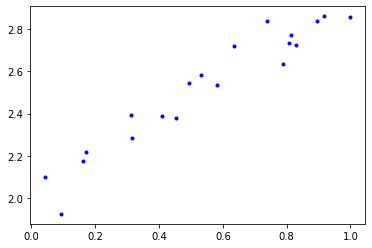

In [6]:
# Create data from a noise contaminated linear model

def MakeNoisyData(m, b, n=20):
    x = tf.random.uniform(shape=(n,))
    noise = tf.random.normal(shape=(len(x),), stddev=0.1)
    y = m * x + b + noise
    return x, y

m=1
b=2
x_train, y_train = MakeNoisyData(m,b)
plt.plot(x_train, y_train, 'b.')

#### Define a linear regression model

In [7]:
from tensorflow.keras.layers import Layer

In [13]:
# Build a custom layer for the linear regression model

class MyLinearLayer(Layer):
  
  def __init__(self):
    super(MyLinearLayer, self).__init__()
    self.m = self.add_weight(shape=(1,),
                              initializer='random_normal')
    self.b = self.add_weight(shape=(1,),
                              initializer='zeros')  
  
  def call(self, inputs):
    return self.m * inputs + self.b

linear_regression = MyLinearLayer()
print(linear_regression(x_train))
print(x_train)
print(linear_regression.weights)


tf.Tensor(
[0.00133782 0.01935308 0.01251462 0.01509684 0.01380814 0.00495006
 0.02405855 0.02461202 0.009515   0.01624025 0.00520578 0.02737495
 0.02530224 0.00284143 0.02796365 0.00966123 0.01779484 0.02483832
 0.03047877 0.02256697], shape=(20,), dtype=float32)
tf.Tensor(
[0.04380739 0.6337229  0.40979528 0.4943509  0.452152   0.16209126
 0.7878052  0.8059286  0.31157196 0.5317923  0.17046487 0.8964019
 0.8285303  0.09304357 0.915679   0.31636024 0.582698   0.813339
 0.9980372  0.73896277], shape=(20,), dtype=float32)
[<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.03053871], dtype=float32)>, <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]


In [16]:
#mx+b
0.03053871 * 0.6337229 + 0

0.019353079863459

#### Define the loss function

In [17]:
# Define the mean squared error loss function

def SquaredError(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_pred - y_true)) 

starting_loss = SquaredError(linear_regression(x_train), y_train)
print("Starting loss", starting_loss.numpy())

Starting loss 6.360185


#### Train and plot the model

In [22]:
# Implement a gradient descent training loop for the linear regression model

learning_rate = 0.05
steps = 25

for i in range(steps):
  with tf.GradientTape() as tape:
    predictions = linear_regression(x_train)
    loss = SquaredError(predictions, y_train)
  
  gradients = tape.gradient(loss, linear_regression.trainable_variables)

  linear_regression.m.assign_sub(learning_rate * gradients[0])
  linear_regression.b.assign_sub(learning_rate * gradients[1])

  print('Step %d Loss %f'%(i, loss.numpy()))

Step 0 Loss 6.360185
Step 1 Loss 4.792069
Step 2 Loss 3.611174
Step 3 Loss 2.721879
Step 4 Loss 2.052176
Step 5 Loss 1.547838
Step 6 Loss 1.168030
Step 7 Loss 0.882000
Step 8 Loss 0.666590
Step 9 Loss 0.504362
Step 10 Loss 0.382182
Step 11 Loss 0.290161
Step 12 Loss 0.220852
Step 13 Loss 0.168647
Step 14 Loss 0.129321
Step 15 Loss 0.099695
Step 16 Loss 0.077374
Step 17 Loss 0.060553
Step 18 Loss 0.047875
Step 19 Loss 0.038316
Step 20 Loss 0.031107
Step 21 Loss 0.025667
Step 22 Loss 0.021560
Step 23 Loss 0.018457
Step 24 Loss 0.016109


m:1,  trained m:[1.0727534]
b:2,  trained b:[1.856056]


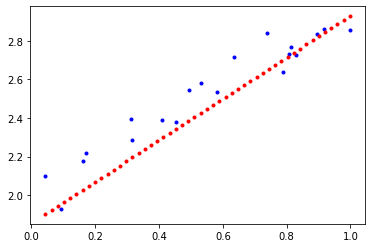

In [23]:
# Plot the learned regression model

print("m:{},  trained m:{}".format(m,linear_regression.m.numpy()))
print("b:{},  trained b:{}".format(b,linear_regression.b.numpy()))

plt.plot(x_train, y_train, 'b.')

x_linear_regression=np.linspace(min(x_train), max(x_train),50)
plt.plot(x_linear_regression, linear_regression.m*x_linear_regression+linear_regression.b, 'r.')

***
<a id="coding_tutorial_4"></a>
## Custom training loops

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

#### Build the model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax

In [ ]:
# Define the custom layers and model



#### Load the reuters dataset and define the class_names 

In [ ]:
# Load the dataset

from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

class_names = ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
   'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
   'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
   'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
   'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead']

In [ ]:
# Print the class of the first sample

print("Label: {}".format(class_names[train_labels[0]]))

#### Get the dataset word index

In [ ]:
# Load the Reuters word index

word_to_index = reuters.get_word_index()

invert_word_index = dict([(value, key) for (key, value) in word_to_index.items()])
text_news = ' '.join([invert_word_index.get(i - 3, '?') for i in train_data[0]])

In [ ]:
# Print the first data example sentence



#### Preprocess the data

In [ ]:
# Define a function that encodes the data into a 'bag of words' representation

def bag_of_words(text_samples, elements=10000):
    output = np.zeros((len(text_samples), elements))
    for i, word in enumerate(text_samples):
        output[i, word] = 1.
    return output

x_train = bag_of_words(train_data)
x_test = bag_of_words(test_data)

print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)

#### Define the loss function and optimizer



In [ ]:
# Define the categorical cross entropy loss and Adam optimizer

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def loss(model, x, y, wd):
    kernel_variables = []
    for l in model.layers:
        for w in l.weights:
            if 'kernel' in w.name:
                kernel_variables.append(w)
    wd_penalty = wd * tf.reduce_sum([tf.reduce_sum(tf.square(k)) for k in kernel_variables])
    y_ = model(x)
    return loss_object(y_true=y, y_pred=y_) + wd_penalty

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

#### Train the model

In [ ]:
# Define a function to compute the forward and backward pass

def grad(model, inputs, targets, wd):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, wd)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [ ]:
# Implement the training loop

from tensorflow.keras.utils import to_categorical

start_time = time.time()

    
    
print("Duration :{:.3f}".format(time.time() - start_time))

#### Evaluate the model

In [ ]:
# Create a Dataset object for the test set

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, test_labels))
test_dataset = test_dataset.batch(32)

In [ ]:
# Collect average loss and accuracy

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

In [ ]:
# Loop over the test set and print scores

from tensorflow.keras.utils import to_categorical

for x, y in test_dataset:
    # Optimize the model
    loss_value = loss(model, x, y, weight_decay)    
    # Compute current loss
    epoch_loss_avg(loss_value)  
    # Compare predicted label to actual label
    epoch_accuracy(to_categorical(y), model(x))

print("Test loss: {:.3f}".format(epoch_loss_avg.result().numpy()))
print("Test accuracy: {:.3%}".format(epoch_accuracy.result().numpy()))

#### Plot the learning curves

In [ ]:
# Plot the training loss and accuracy

fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

#### Predict from the model

In [ ]:
# Get the model prediction for an example input

predicted_label = np.argmax(model(x_train[np.newaxis,0]),axis=1)[0]
print("Prediction: {}".format(class_names[predicted_label]))
print("     Label: {}".format(class_names[train_labels[0]]))

***
<a id="coding_tutorial_5"></a>
## tf.function decorator

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import reuters
import numpy as np
import matplotlib.pyplot as plt
import time

#### Build the model

In [ ]:
# Initialize a new model



#### Redefine the grad function using the @tf.function decorator

In [ ]:
# Use the @tf.function decorator



#### Train the model

In [ ]:
# Re-run the training loop



#### Print the autograph code

In [ ]:
# Use tf.autograph.to_code to see the generated code

